# Import block

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Lib.tab import tables_side

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_air = pd.read_csv('df_air.csv',index_col=0)

In [4]:
df_covid = pd.read_csv('df_covid.csv', index_col=0)

In [5]:
df_demo = pd.read_csv('df_demo.csv',index_col=0)

In [6]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 7 columns):
Codice zona                  76 non-null object
id                           76 non-null int64
Regione                      76 non-null object
Tipo zona                    76 non-null object
classificazione              76 non-null object
superamento VL               76 non-null object
max media annuale (mg/m3)    76 non-null int64
dtypes: int64(2), object(5)
memory usage: 4.8+ KB


# Main data table creation

In [7]:
df_summary = df_covid[['codice_regione', 'denominazione_regione', 'deceduti']]

In [8]:
df_summary = df_summary.merge(df_demo, left_on='denominazione_regione', right_on='denominazione_regione')

In [9]:
df_summary['death%'] = df_summary['deceduti']/df_summary['popolazione']*100

In [10]:
df_air_med = df_air.groupby(['Regione']).agg({'max media annuale (mg/m3)': ['count', 'mean', 'median']})

In [11]:
tables_side(titolo='Comparison between',
            tabs=[df_summary.sort_values(by='death%', ascending=False), df_air_med.sort_values(by=('max media annuale (mg/m3)', 'median'), ascending=False)],
            tabslabel=['Summary COVID ord by Death%','Summary Air Pollution'])

<b>Adesso ho due dataframe:</b>
* df_summary che contiene la lista delle regione, i deceduti e i deceduti in proporzione alla popolazione (più altri dati come popolazione e id regione
* df_air_med che contiene i valori di inquinamento dell'aria per regione, ho il calcolo della media e della mediana dei valori

Il mio obiettivo sarà riunire questi dati in un unico dataframe, per comodità accorperò tutto in <b>df_summary</b>, per l'inquinamento terrò solo la colonna della mediana

In [12]:
df_summary = df_summary.sort_values(by='death%', ascending=False).merge(df_air_med, left_on='denominazione_regione',right_on='Regione')
df_summary = df_summary.iloc[:,[0,1,2,3,4,7]]
df_summary.columns = ['codice_regione',
               'denominazione_regione',
                            'deceduti',
                         'popolazione',
                              'death%',
                     'air_poll_median']

In [13]:
df_summary.head(3)

,codice_regione,denominazione_regione,deceduti,popolazione,death%,air_poll_median
0,3,Lombardia,7593,10060574,0.075473,27.0
1,2,Valle d'Aosta,59,125666,0.046950,12.0
2,4,P.A. Trento,173,541098,0.031972,10.5


In [14]:
df_covid_complete = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
df_covid_complete.head(3)

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN


In [15]:
df_covid_complete.loc[df_covid_complete.denominazione_regione=='Emilia-Romagna','denominazione_regione'] = 'Emilia Romagna'

In [16]:
list_Regions = df_demo.denominazione_regione
dfCVprop = df_covid_complete[['data', 'denominazione_regione', 'deceduti','totale_ospedalizzati']]

In [17]:
for i in list_Regions:
    dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti'] = dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti']/df_demo[df_demo.denominazione_regione==i]['popolazione'].values*100
    dfCVprop.loc[dfCVprop.denominazione_regione==i,'totale_ospedalizzati'] = dfCVprop.loc[dfCVprop.denominazione_regione==i,'totale_ospedalizzati']/df_demo[df_demo.denominazione_regione==i]['popolazione'].values*100

In [18]:
df_main = dfCVprop.pivot_table(index='denominazione_regione', columns='data', values='deceduti').transpose()

In [19]:
df=df_covid_complete
lista_Regioni = df.denominazione_regione.unique()
tot = len(df[df['denominazione_regione']=='Lombardia'].loc[:,'deceduti'])

In [20]:
for l in lista_Regioni:
    dec = df[df.denominazione_regione==l]['deceduti'].index
    val =df[df.denominazione_regione==l]['deceduti'].values
    valosp =df[df.denominazione_regione==l]['totale_ospedalizzati'].values
    a = val[0]
    b = valosp[0]
    for x in range(1,tot):
        df.loc[dec[x-1],'nuovi_dec'] = a
        df.loc[dec[x-1],'nuovi_osp'] = b
        a = val[x]-val[x-1]
        b = valosp[x]-valosp[x-1]
    df.loc[dec[tot-1],'nuovi_dec'] = val[tot-1]-val[tot-2]
    df.loc[dec[tot-1],'nuovi_osp'] = valosp[tot-1]-valosp[tot-2]

### Conclusion
Adesso possiedo 4 tabelle di dati:
* <b>df_summary</b>: che contiene i dati delle regioni,riguardanti l'inquinamento dell'aria e dei morti in percentuale alla popolazione ('codice_regione', 'denominazione_regione', 'deceduti', 'popolazione', 'death%', 'air_poll_median')
* <b>df_covid_complete</b>: dataframe completo dal sito github della Protezione Civile, ha tutti le colonne originali
* <b>dfCVprop</b>: datateset di <b>df_covid_complete</b> da cui sono stati estrapolati solamente i dati relativi dalla data di rilevazione, regione e deceduti che sono stati normalizzati in base alla popolazione della regione
* <b>df_main</b>: semplicemente la tabella pivot del dataframe <b>dfCVprop</b> come colonne ha le regioni e come index ha la data delle rilevazioni, la tengo per comodità
* <b>df</b>: il dataframe originale df_covid_complete a cui ho aggiunto la progressione dei deceduti e degli ospedalizzati

# Data Exploration

Inizio ad esaminare l'andamento del contagio visualizzando il progressivo degli ospedalizzati e dei deceduti in 6 regioni scelte

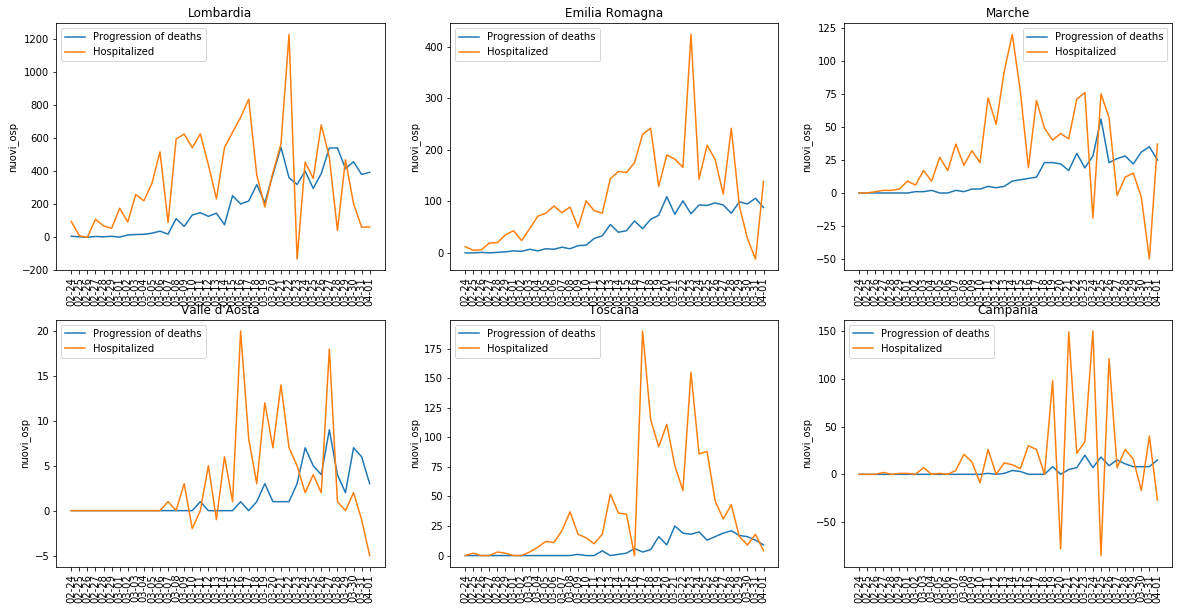

In [21]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania']
datagiorn=df.data.str[5:10]
plt.figure(figsize=(20,10))
for i, r in zip (l, range(len(l))):
    plt.subplot(2,3,r+1)
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_dec'], label='Progression of deaths')
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_osp'], label='Hospitalized')
    plt.title(i)
    plt.xticks(rotation=90)

Di seguito il Grafico dei morti in percentuale alla popolazione con la tabella relativa

In [22]:
df_main.columns

Index(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d'Aosta', 'Veneto'],
      dtype='object', name='denominazione_regione')

Si può notare che, nonostante alcune regioni come ad esempio la Val d'Aosta, abbiano pochi morti assoluti, messi in relazione alla popolazione hanno un numero di morti più significativo


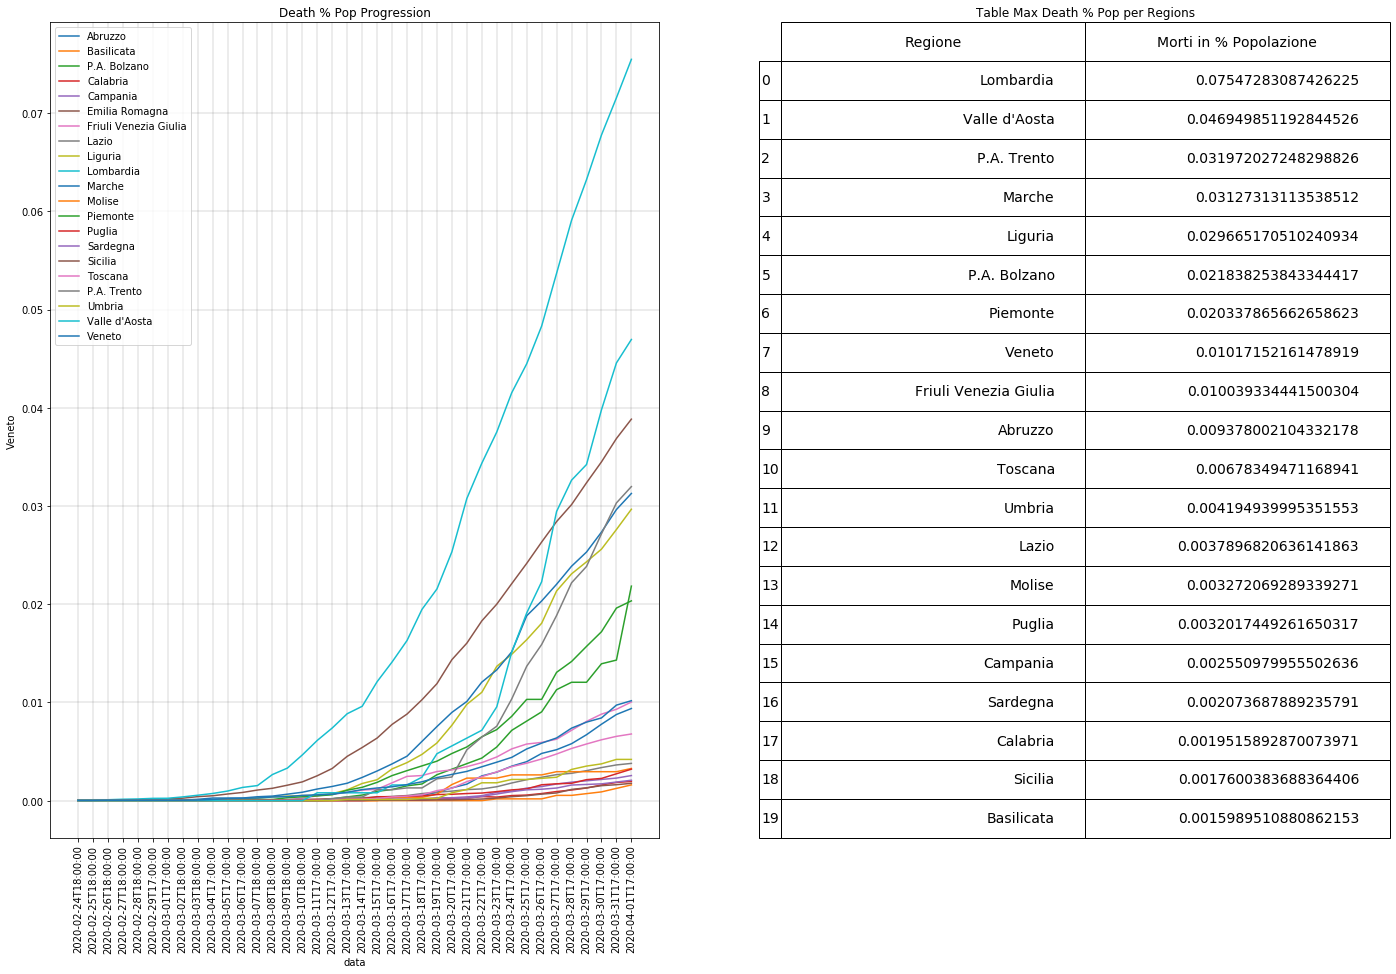

In [23]:
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(121)

for i  in list_Regions:
    ax1=sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i)
ax1.grid(color='gray', linestyle='-', linewidth=0.3)
ax1.legend()
plt.xticks(rotation=90)
plt.title('Death % Pop Progression')

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
plt.title('Table Max Death % Pop per Regions')

mpl_table = ax2.table(cellText = df_summary.iloc[:,[1,4]].sort_values(by='death%',ascending=False).values, rowLabels = df_summary.iloc[:,[1,4]].index, bbox=bbox, colLabels=['Regione','Morti in % Popolazione'],)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
print("Si può notare che, nonostante alcune regioni come ad esempio la Val d'Aosta, abbiano pochi morti assoluti, messi in relazione alla popolazione hanno un numero di morti più significativo")

In [24]:
list_Regions

0                   Abruzzo
1                Basilicata
2              P.A. Bolzano
3                  Calabria
4                  Campania
5            Emilia Romagna
6     Friuli Venezia Giulia
7                     Lazio
8                   Liguria
9                 Lombardia
10                   Marche
11                   Molise
12                 Piemonte
13                   Puglia
14                 Sardegna
15                  Sicilia
16                  Toscana
17              P.A. Trento
18                   Umbria
19            Valle d'Aosta
20                   Veneto
Name: denominazione_regione, dtype: object

Iniziamo a vedere se l'inquinamento è relazionambile con il numero di morti attraverso la correlazione delle features

In [25]:
heatmapshow = df_summary[['denominazione_regione',
                                       'deceduti',
                                         'death%',
                                    'popolazione',
                                'air_poll_median']].corr()


In [26]:
heatmapshow

,deceduti,death%,popolazione,air_poll_median
deceduti,1.000000,0.755207,0.716029,0.539076
death%,0.755207,1.000000,0.299102,0.229576
popolazione,0.716029,0.299102,1.000000,0.800719
air_poll_median,0.539076,0.229576,0.800719,1.000000


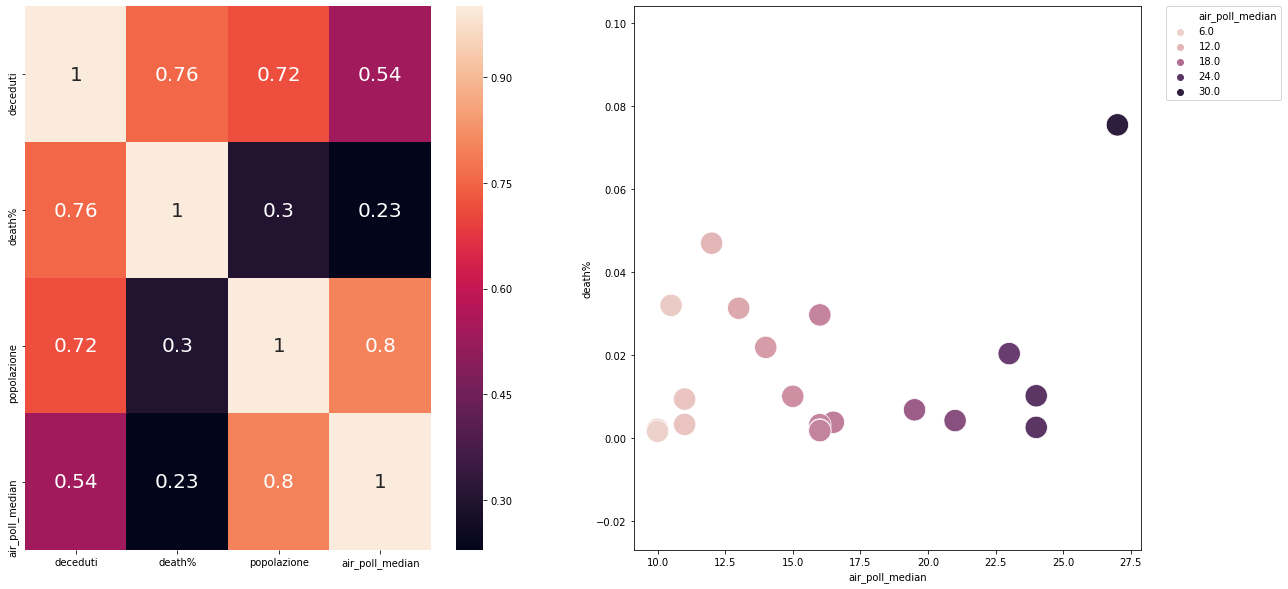

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(122)
sns.scatterplot(x=df_summary.iloc[:,5], y= df_summary['death%'], data=df_summary, hue='air_poll_median', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(121)
sns.heatmap(heatmapshow, annot=True, annot_kws={'size':20})

Da questa prima relazione inquinamento e morte sono solo moderatamente correlati. 

***
Successivamente attraverso dei clustermap cerco relazioni tra regioni. Realizzerò un set di cluster (Normalizzato e Non Normalizzato):
* sui dati dei deceduti <u>NON proporzionati</u> alla popolazione 
* sui dati dei deceduti <u>proporzionati</u> alla popolazione

In [28]:
pivtable = df_covid_complete.pivot_table(index='denominazione_regione', columns='data', values='deceduti')

## Dati dei deceduti <u>NON proporzionati</u> alla popolazione

Questi primi grafici sono realizzati con dati assoluti dei decessi, numeri non proporzionati alla popolazione. Come si potrà notare a parte la Lombardia non si riescono a notare le altre regioni coinvolte.

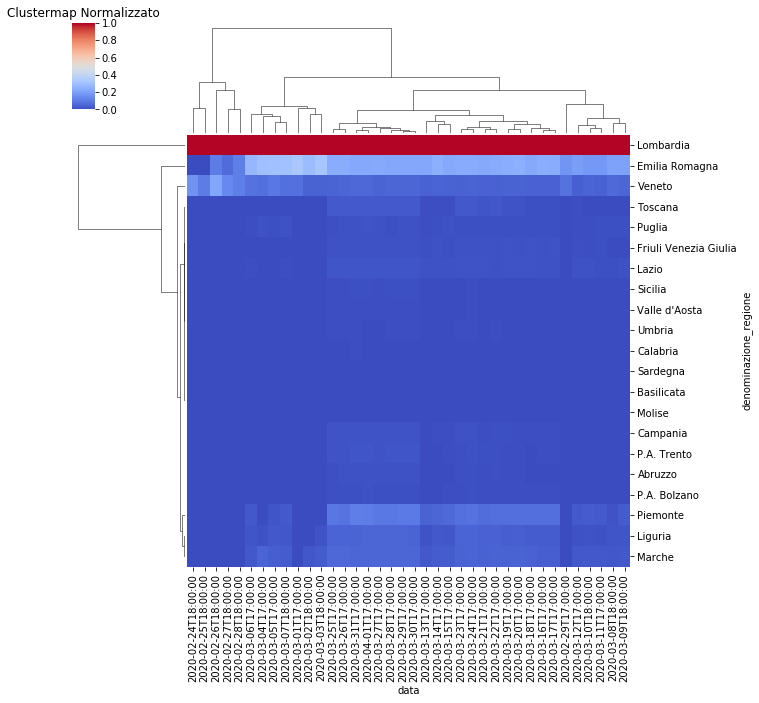

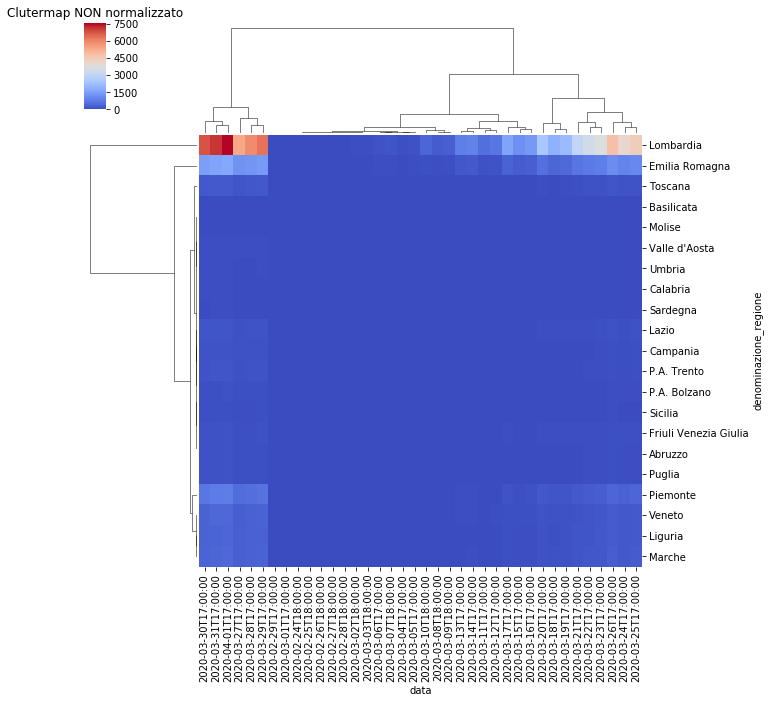

In [29]:
sns.clustermap(pivtable, cmap='coolwarm', standard_scale=1)
plt.title('Clustermap Normalizzato')

sns.clustermap(pivtable, cmap='coolwarm')
plt.title('Clutermap NON normalizzato')
plt.show()


## Dati dei deceduti <u>proporzionati</u> alla popolazione

Text(0.5, 1, 'Clustermap Normalizzato')

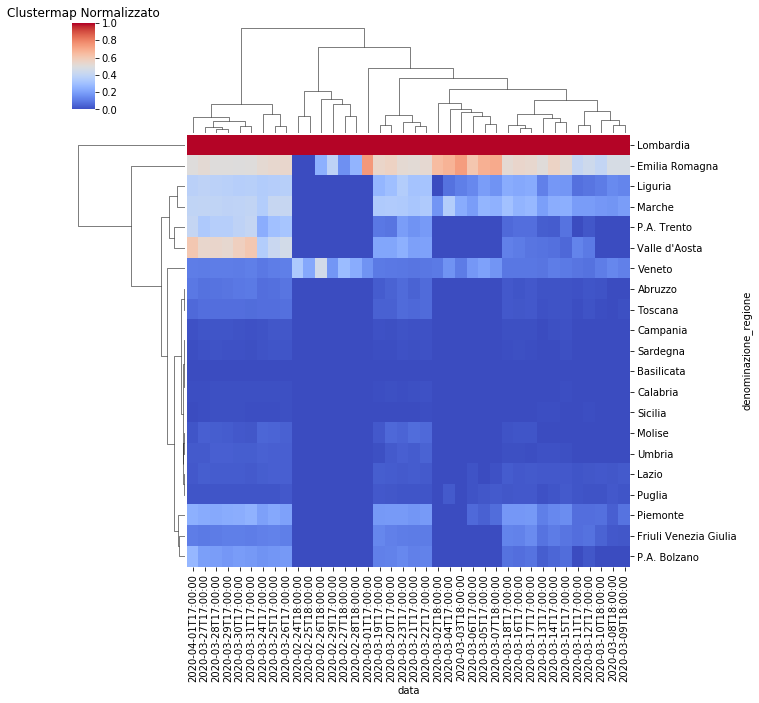

In [30]:
import matplotlib.gridspec
i='Emilia Romagna'
sns.clustermap(df_main.transpose(), cmap='coolwarm', standard_scale=1, figsize=(10,10))
plt.title('Clustermap Normalizzato')

In [31]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania', 'Molise']

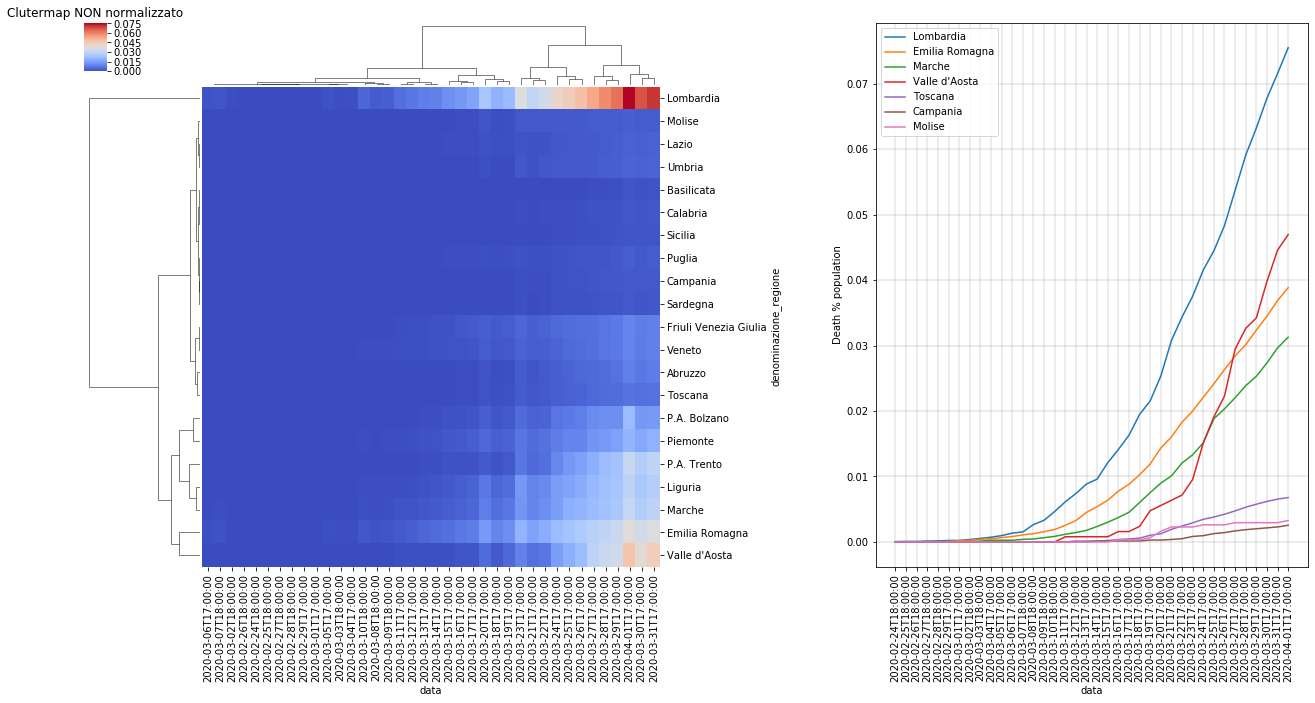

In [32]:
g = sns.clustermap(df_main.transpose(), cmap='coolwarm',figsize=(20,10))
g.gs.update(left=0.05, right=0.45)
plt.title('Clutermap NON normalizzato')
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
for i in l:
    sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i, ax=ax2)
plt.ylabel('Death % population')
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.xticks(rotation=90)
plt.legend(loc='upper left')


plt.show()

I dati proporzionati risultano, a mio parere, più visibili, dalla clustermap si delineano la presenza di tre gruppi principali:
* Lombardia
* Marche, Liguria, Valle d'Aosta, Piemonte, Trentino Alto Adige, Emilia Romagna e Veneto
* le restanti regioni italiane
tale suddivisione si può notare anche dall'andamento delle linee dei decessi nel grafico accanto, anche meno chiaro.

Per ora per i dati visualizzati non mostrano una relazione evidente tra inquinamento e morte per polmonite interstiziale da Coronavirus, tuttavia la regione Lombardia, <u>l'unica con un valore superiore</u> a quelli consetiti dalla legge, è la regione che ha subito il maggior numero di decessi attribuiti all'azione del virus.

***

Per concludere questo processo di visualizzazione introduttiva dei dati realizzerò dei grafici geoplot per avere una visione forse più friendly dei dati.
Utilizzerò due libreire differenti con approcci diversi, da una parte geopandas e dall'altra ipyleaflet

## Geoplotting with geopandas

In [33]:
import geopandas as gpd

In [34]:
# le librerie json che ho trovato in rete non hanno gli stessi nomi di provincie e regioni delle mie tabelle
# ho uniformato per poterle mettere in relazione non perdere dati.
# voglio visualizzare dei grafici sia per regione che per provincia

# il file originale si può trovare qui, https://gist.github.com/datajournalism-it/f1abb68e718b54f6a0fe,
# le mie versioni SONO UNIFORMATE con le mie tabelle

reg_json = gpd.read_file('Lib/reg_ok_2020.geojson')

# il fle originale per le province si può trovare qui https://gist.github.com/datajournalism-it/212e7134625fbee6f9f7
prov_json = gpd.read_file('Lib/prov_ok_2020.geojson')


Il dataframe df_summary continene gia tutte le infomazioni che mi servono per la visualizzazione dei geoplot delle regioni, devo solo intergrare le coordinate dei poligoni che rappresentano le regioni contenuti nel file json

In [35]:
vis = reg_json.merge(df_summary, how='left', left_on='Regione', right_on = 'denominazione_regione')

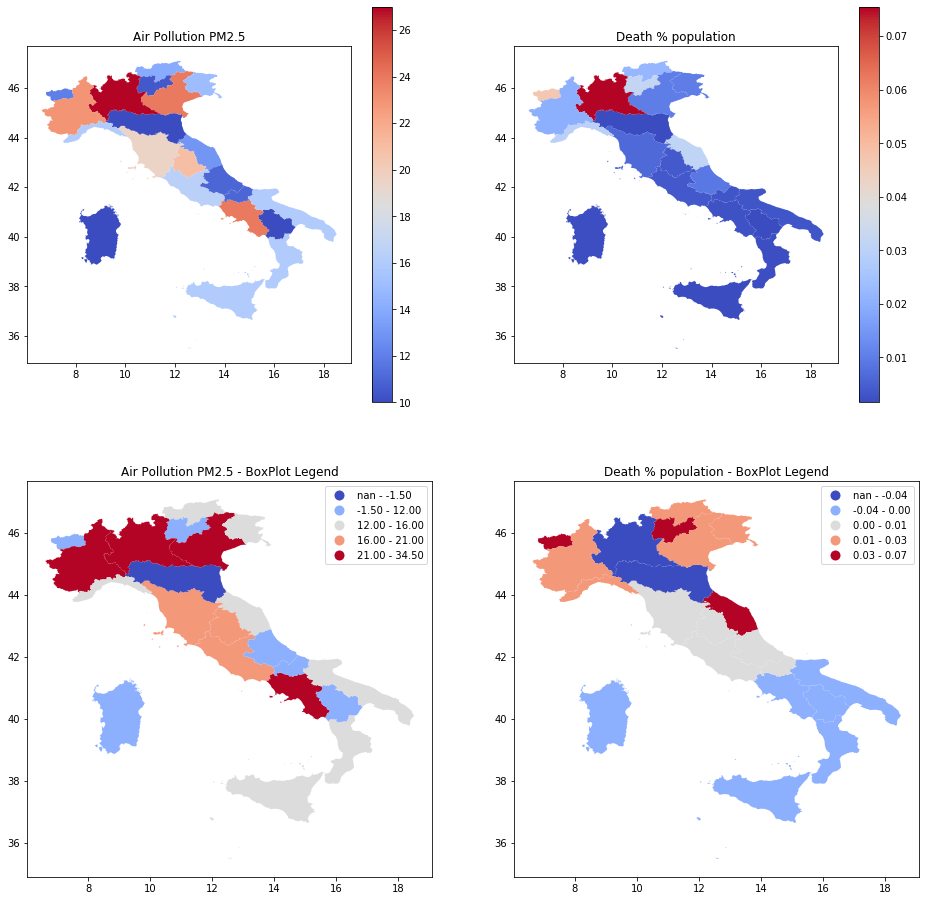

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax[0][0].set_title('Air Pollution PM2.5')
vis.plot(column='air_poll_median', ax=ax[0][0], cmap='coolwarm', legend=True)
ax[0][1].set_title('Death % population')
vis.plot(column='death%', ax=ax[0][1], cmap='coolwarm', legend=True)
ax[1][0].set_title('Air Pollution PM2.5 - BoxPlot Legend')
vis.plot(column='air_poll_median', ax=ax[1][0], cmap='coolwarm', legend=True, scheme='BoxPlot')
ax[1][1].set_title('Death % population - BoxPlot Legend')
vis.plot(column='death%', ax=ax[1][1], cmap='coolwarm', legend=True, scheme='BoxPlot')

plt.show()


I primi due grafici rappresentano i valori con una legenda cromatica basata sui valori, negli altri due i valori vengono divisi in 5 classi tramite il classificatore Box Plot (o  "Box and wiskers plot"), che combina i valori minimo e massimo (e quindi l'intervallo) con i quartili per evidenziare l'indice di dispersione dei valori


Ad ora l'unica correlazione continua ad essere presente solo in Lombardia, è da ricordare che l'unica regione italiana ad avere un indice di inquinamento dell'aria maggiore alla soglia è la Lombardia.


***

Eseguirò la stessa cosa anche per le provincie, purtroppo il database di cui dispongo non ha numeri dei morti per provincia e dovrò utilizzare il valore relativo al totale dei casi. Le problematiche sono quelle discusse all'inizio, sono dei dati che sono molto relativi, come quelli dei contagiati, e sopratutti in questo caso non ci sono neanche dati relativi al numero di posti letto per provincia, tuttavia proverò comunque a rapprensentarli.

In [37]:
ap_prov =  pd.read_excel('Data/air_pollution_data/Tabella 2.xlsx', header=1)
ap_prov.head(5)

,Region_id,Province_id,Municipality_id,Observation_id,Station_code,Station_eu_code,Regione,Provincia,Comune,Nome della stazione,...,Tipo di stazione,Tecnica di misura,"Valore medio annuo1,3 [µg/m³]",50° percentile1 [µg/m3],75° percentile2 [µg/m3],98° percentile2 [µg/m3],"99,2° percentile2 [µg/m3]",Valore massimo2 [µg/m3],Numero di dati validi,AQD used4
0,1.0,1,1001028,30068,100114,IT1128A,Piemonte,Torino,Borgaro Torinese,Borgaro T. - Caduti,...,background,g,27,20,38,81,94,158,348,t
1,1.0,1,1001078,30246,100171,IT2101A,Piemonte,Torino,Chieri,Chieri - Bersezio,...,background,g,27,18,39,82,85,97,341,t
2,1.0,1,1001125,30177,100165,IT1788A,Piemonte,Torino,Ivrea,Ivrea - Liberazione,...,background,g,24,16,33,81,95,104,350,t
3,1.0,1,1001130,30271,100172,IT2117A,Piemonte,Torino,Leinì,Leinì (ACEA) - Grande Torino,...,background,b,26,17,40,78,83,94,321,t
4,1.0,1,1001265,30076,100129,IT1130A,Piemonte,Torino,Settimo Torinese,Settimo T. - Vivaldi,...,traffic,g,30,18,42,92,100,161,359,t


In [38]:
ap_prov =  pd.read_excel('Data/air_pollution_data/Tabella 2.xlsx', header=1)
ap_prov.head(5)
ap_prov[ap_prov['50° percentile1 [µg/m3]'].str.contains('-', na=False)]
ap_prov.drop(ap_prov[ap_prov['50° percentile1 [µg/m3]']=='-'].index, inplace=True)
ap_prov['50° percentile1 [µg/m3]']=pd.to_numeric(ap_prov['50° percentile1 [µg/m3]'])

ap_prov[ap_prov['75° percentile2 [µg/m3]'].str.contains('-', na=False)]
ap_prov.drop(ap_prov[ap_prov['75° percentile2 [µg/m3]']=='-'].index, inplace=True)
ap_prov['75° percentile2 [µg/m3]']=pd.to_numeric(ap_prov['75° percentile2 [µg/m3]'])

df = ap_prov.groupby(by='Provincia').median()
df.columns = ['Region_id', 'Province_id', 'Municipality_id', 'Observation_id',
       'Station_code', 'airpoll_50perc', 'airpoll_75perc', 'Numero di dati validi']
df.reset_index(inplace=True)
df.head(5)

,Provincia,Region_id,Province_id,Municipality_id,Observation_id,Station_code,airpoll_50perc,airpoll_75perc,Numero di dati validi
0,Agrigento,19.0,84.0,19084014.5,28498.0,1908497.5,11.000000,15.400000,300.0
1,Alessandria,1.0,6.0,1006034.5,30204.0,100612.5,13.000000,24.500000,362.5
2,Ancona,11.0,42.0,11042016.0,28174.0,1104216.5,9.507143,14.547024,328.5
3,Aosta,2.0,7.0,2007003.0,29993.5,200711.5,9.500000,17.500000,362.0
4,Arezzo,9.0,51.0,9051002.0,28426.0,905103.0,10.000000,15.000000,352.0


Dopo aver estrapolato i dati relativi all'inquinamento per provincia, raggruppo il numero di ospedalizzati per provincia e li accorpo le due tabelle.

In [39]:
df_covid_prov = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
df_covid_prov.loc[df_covid_prov['denominazione_provincia']=='Forlì-Cesena','denominazione_provincia'] = 'Forlì -Cesena'


In [40]:
df_covid_prov.loc[df_covid_prov['denominazione_provincia']=='In fase di definizione/aggiornamento','denominazione_provincia']
df_covid_prov.drop(df_covid_prov[df_covid_prov['denominazione_provincia']=='In fase di definizione/aggiornamento'].index, inplace=True)

In [41]:
df_prov = df_covid_prov.groupby('denominazione_provincia').median()
df_prov.reset_index(inplace=True)

In [42]:
df = df_prov.merge(df, how='left', left_on='denominazione_provincia', right_on='Provincia')
df.head(3)

,denominazione_provincia,codice_regione,codice_provincia,lat,long,totale_casi,Provincia,Region_id,Province_id,Municipality_id,Observation_id,Station_code,airpoll_50perc,airpoll_75perc,Numero di dati validi
0,Agrigento,19.0,84.0,37.309711,13.584575,17.0,Agrigento,19.0,84.0,19084014.5,28498.0,1908497.5,11.000000,15.400000,300.0
1,Alessandria,1.0,6.0,44.912974,8.615401,159.0,Alessandria,1.0,6.0,1006034.5,30204.0,100612.5,13.000000,24.500000,362.5
2,Ancona,11.0,42.0,43.616760,13.518875,186.5,Ancona,11.0,42.0,11042016.0,28174.0,1104216.5,9.507143,14.547024,328.5


In [43]:

#df.groupby('codice_regione').sum().sort_values('totale_casi', ascending=False)
#df_summary.loc[df_summary.codice_regione.isin([1,2,3,4])]
#df_summary.iloc[:,[1,2,3,4]]
df.merge(df_summary, how='left', left_on='codice_regione', right_on='codice_regione').groupby(['denominazione_regione','codice_regione']).sum().sort_values('totale_casi', ascending=False)['totale_casi']


denominazione_regione  codice_regione
Lombardia              3.0               10190.0
Veneto                 5.0                1668.5
Marche                 11.0                806.5
Piemonte               1.0                 744.5
Toscana                9.0                 550.0
Liguria                7.0                 351.0
P.A. Trento            4.0                 333.5
P.A. Bolzano           4.0                 333.5
Lazio                  12.0                313.0
Friuli Venezia Giulia  6.0                 270.5
Campania               15.0                241.0
Puglia                 16.0                147.5
Sicilia                19.0                115.0
Abruzzo                13.0                100.5
Umbria                 10.0                 76.0
Sardegna               20.0                 44.5
Calabria               18.0                 44.0
Valle d'Aosta          2.0                  35.0
Molise                 14.0                 17.0
Basilicata             17.0    

In [44]:
df = df.loc[:,['denominazione_provincia','totale_casi','airpoll_50perc', 'airpoll_75perc']]
#df.info()

I dati relativi all'inquinamento dell'aria sono relativi al 50esimo percentile e al 75esimo percentile. Ho preso queste due misure per vedere se diventano più evidenti correlazioni con l'inquinamento

In [45]:
df = df.loc[:,['denominazione_provincia','totale_casi','airpoll_50perc', 'airpoll_75perc']]
df['airpoll_50perc'].dropna(inplace=True)
df['airpoll_75perc'].dropna(inplace=True)

In [46]:
df.head(3)

,denominazione_provincia,totale_casi,airpoll_50perc,airpoll_75perc
0,Agrigento,17.0,11.000000,15.400000
1,Alessandria,159.0,13.000000,24.500000
2,Ancona,186.5,9.507143,14.547024


Ora unisco la tabella ottenuta al json delle provincie

In [47]:
vis_prov = prov_json.merge(df, how='left', left_on='NOME_PRO', right_on = 'denominazione_provincia')

In [48]:
vis_prov.dropna(inplace=True)
a = vis_prov.sort_values('totale_casi', ascending=False).head(10).loc[:,['denominazione_provincia','totale_casi']]
b = vis_prov.sort_values('airpoll_50perc', ascending=False).head(10).loc[:,['denominazione_provincia','airpoll_50perc']]
c = vis_prov.sort_values('airpoll_75perc', ascending=False).head(10).loc[:,['denominazione_provincia','airpoll_75perc']]
tables_side(titolo='Confronto provincie', tabs=[a,b,c], tabslabel=['Total cases','Pollution PM 2.5 - 50 percentile','Pollution PM 2.5 - 75 percentile'])

Total cases,Pollution PM 2.5 - 50 percentile,Pollution PM 2.5 - 75 percentile
,denominazione_provincia,totale_casi
15,Bergamo,2616.0
16,Brescia,1953.0
19,Cremona,1454.5
13,Milano,1429.0
81,Lodi,1204.5
34,Piacenza,781.5
28,Padova,567.0
14,Pavia,552.0
31,Parma,544.0


In [49]:
tableAP =pd.concat([b.reset_index(drop=True), c.reset_index(drop=True)], axis=1)
tableAP.loc[:, 'airpoll_50perc'] = tableAP.loc[:, 'airpoll_50perc'].round(2)
tableAP.loc[:, 'airpoll_75perc'] = tableAP.loc[:, 'airpoll_75perc'].round(2)
tableAP.columns =['prov1', 'airpoll_50perc', 'prov2', 'airpoll_75perc']
tableAP.loc[tableAP.prov1=='Monza e della Brianza','prov1'] = 'Monza Brianza'
tableAP.loc[tableAP.prov2=='Monza e della Brianza','prov2'] = 'Monza Brianza'
tableAP

,prov1,airpoll_50perc,prov2,airpoll_75perc
0,Cremona,23.60,Cremona,41.50
1,Monza Brianza,23.00,Torino,39.50
2,Brescia,22.20,Monza Brianza,39.40
3,Como,20.30,Padova,39.00
4,Piacenza,20.00,Milano,38.60
5,Terni,19.50,Mantova,36.58
6,Milano,19.40,Venezia,36.00
7,Mantova,19.28,Pavia,35.40
8,Bergamo,18.42,Rovigo,35.00
9,Pavia,18.09,Brescia,34.80


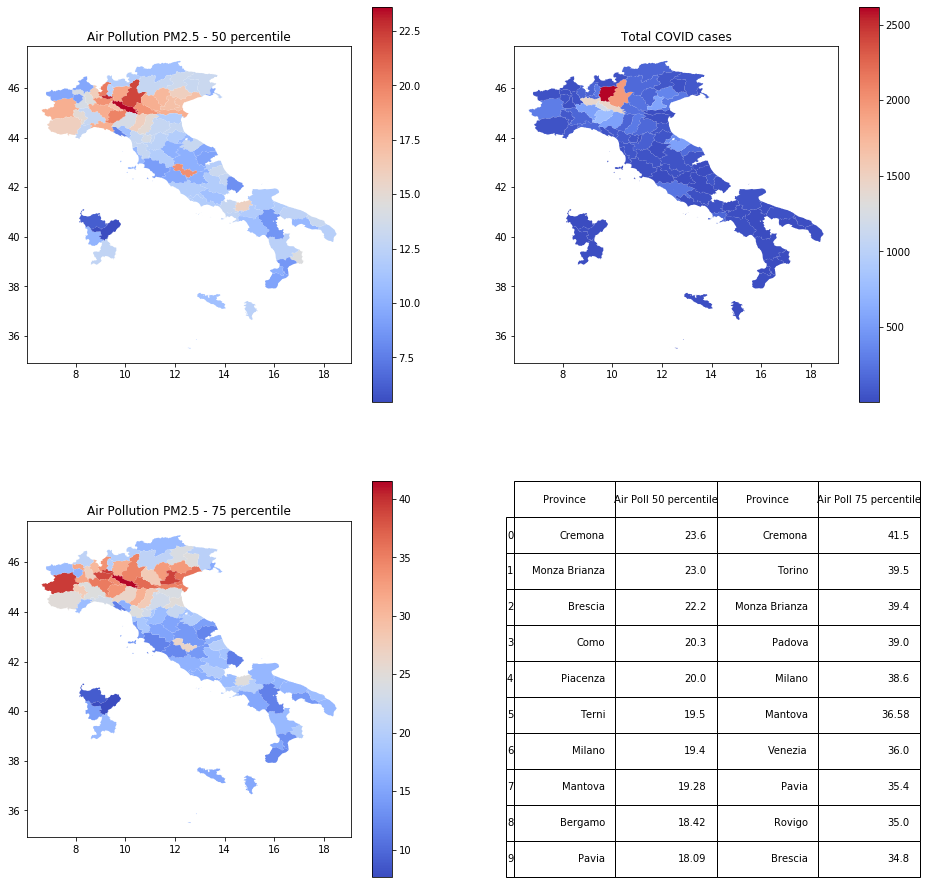

In [50]:


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax[0][0].set_title('Air Pollution PM2.5 - 50 percentile')
vis_prov.plot(column='airpoll_50perc', ax=ax[0][0], cmap='coolwarm', legend=True )
ax[0][1].set_title('Total COVID cases')
vis_prov.plot(column='totale_casi', ax=ax[0][1], cmap='coolwarm', legend=True)
ax[1][0].set_title('Air Pollution PM2.5 - 75 percentile')
vis_prov.plot(column='airpoll_75perc', ax=ax[1][0], cmap='coolwarm', legend=True)

ax[1][1].axis('off')
table = ax[1][1].table(cellText = tableAP.values, rowLabels = tableAP.index, bbox=bbox, colLabels=['Province','Air Poll 50 percentile', 'Province', 'Air Poll 75 percentile'],)
table.auto_set_font_size(False)
mpl_table.set_fontsize(14)

plt.show()

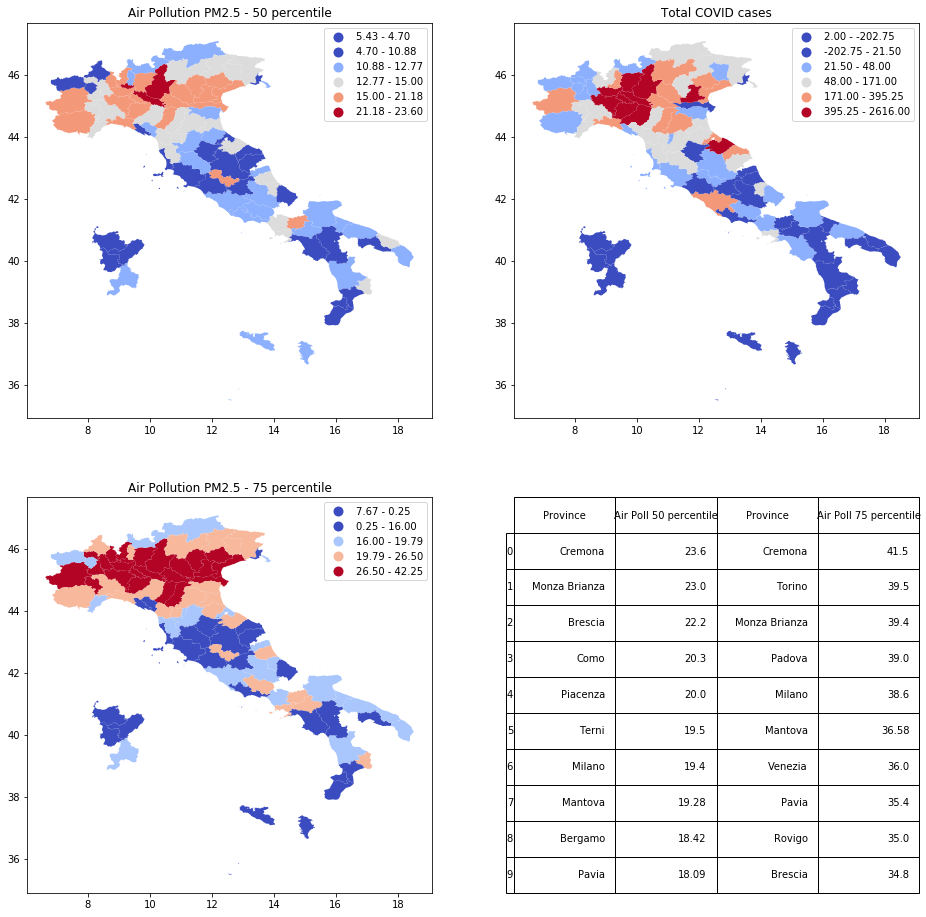

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

ax[0][0].set_title('Air Pollution PM2.5 - 50 percentile')
vis_prov.plot(column='airpoll_50perc', ax=ax[0][0], cmap='coolwarm', legend=True , scheme='box_plot')
ax[0][1].set_title('Total COVID cases')
vis_prov.plot(column='totale_casi', ax=ax[0][1], cmap='coolwarm', legend=True, scheme='box_plot')
ax[1][0].set_title('Air Pollution PM2.5 - 75 percentile')
vis_prov.plot(column='airpoll_75perc', ax=ax[1][0], cmap='coolwarm', legend=True , scheme='box_plot')

ax[1][1].axis('off')
table = ax[1][1].table(cellText = tableAP.values, rowLabels = tableAP.index, bbox=bbox, colLabels=['Province','Air Poll 50 percentile', 'Province', 'Air Poll 75 percentile'],)
table.auto_set_font_size(False)
mpl_table.set_fontsize(14)

plt.show()

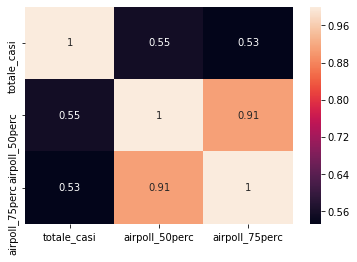

In [52]:
sns.heatmap(vis_prov.corr(), annot=True)

Il totale dei casi non è proporzionato agli abitanti delle province per mancanza di dati. Appena possibile provvederò ad integrare questo dato.

# Geoplotting with ipyleaflet

In [53]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: ok


In [54]:
from ipyleaflet import GeoJSON
from ipyleaflet import (Map, DrawControl, basemaps, Circle, Heatmap, LayersControl, Marker)
import json
import os
import requests
import pandas as pd

In [55]:
if not os.path.exists('Lib/prov2020.geo.json'):
  url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson'
  r = requests.get(url)
  with open('Lib/prov2020.geo.json', 'w') as f:
    f.write(r.content.decode("utf-8"))

with open('Lib/prov2020.geo.json', 'r') as f:
  data = json.load(f)

In [56]:
m = Map(center=[41.9, 12.50], basemap=basemaps.Stamen.Toner, zoom=6)

In [57]:
ap_prov = pd.read_excel('Data/air_pollution_data/Tabella 2.xlsx', header=1)
df_demo = pd.read_csv('df_demo.csv',index_col=0)

In [58]:
df_demo.sort_values('denominazione_regione')['denominazione_regione'].unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

In [59]:
ap_prov.sort_values('Regione')['Regione'].unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia-Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Piemonte', 'Provincia Autonoma Bolzano',
       'Provincia Autonoma Trento', 'Puglia', 'Sardegna', 'Sicilia',
       'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto'], dtype=object)

In [60]:
ap_prov.loc[ap_prov.Regione=='Emilia-Romagna','Regione'] = 'Emilia Romagna'
ap_prov.loc[ap_prov.Regione=='Friuli Venezia-Giulia','Regione'] = 'Friuli Venezia Giulia'
ap_prov.loc[ap_prov.Regione=='Provincia Autonoma Bolzano','Regione'] = 'P.A. Bolzano'
ap_prov.loc[ap_prov.Regione=='Provincia Autonoma Trento','Regione'] = 'P.A. Trento'

In [61]:
ap_prov = ap_prov.merge(df_demo, how='left', left_on='Regione', right_on='denominazione_regione')


In [62]:
ap_prov[ap_prov['50° percentile1 [µg/m3]'].str.contains('-', na=False)]
ap_prov.drop(ap_prov[ap_prov['50° percentile1 [µg/m3]']=='-'].index, inplace=True)
ap_prov['50° percentile1 [µg/m3]']=pd.to_numeric(ap_prov['50° percentile1 [µg/m3]'])
df = ap_prov.groupby(by='Provincia').median()
df.columns = ['Region_id', 'Province_id', 'Municipality_id', 'Observation_id',
       'Station_code', 'airpoll', 'Numero di dati validi', 'Popolazione']
df.reset_index(inplace=True)

In [63]:
ap_prov

,Region_id,Province_id,Municipality_id,Observation_id,Station_code,Station_eu_code,Regione,Provincia,Comune,Nome della stazione,...,"Valore medio annuo1,3 [µg/m³]",50° percentile1 [µg/m3],75° percentile2 [µg/m3],98° percentile2 [µg/m3],"99,2° percentile2 [µg/m3]",Valore massimo2 [µg/m3],Numero di dati validi,AQD used4,denominazione_regione,popolazione
0,1.0,1,1001028,30068,100114,IT1128A,Piemonte,Torino,Borgaro Torinese,Borgaro T. - Caduti,...,27,20.00,38,81,94,158,348,t,Piemonte,4356406
1,1.0,1,1001078,30246,100171,IT2101A,Piemonte,Torino,Chieri,Chieri - Bersezio,...,27,18.00,39,82,85,97,341,t,Piemonte,4356406
2,1.0,1,1001125,30177,100165,IT1788A,Piemonte,Torino,Ivrea,Ivrea - Liberazione,...,24,16.00,33,81,95,104,350,t,Piemonte,4356406
3,1.0,1,1001130,30271,100172,IT2117A,Piemonte,Torino,Leinì,Leinì (ACEA) - Grande Torino,...,26,17.00,40,78,83,94,321,t,Piemonte,4356406
4,1.0,1,1001265,30076,100129,IT1130A,Piemonte,Torino,Settimo Torinese,Settimo T. - Vivaldi,...,30,18.00,42,92,100,161,359,t,Piemonte,4356406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,20.0,92,20092121,27295,2009239,IT2011A,Sardegna,Cagliari,Seulo,CENSE0,...,7,6.00,7.2,15.4,23,27.3,348,f,Sardegna,1639591
274,20.0,92,20092109,27312,2009238,IT1993A,Sardegna,Cagliari,Monserrato,CENMO1,...,15,12.76,17.64,41.58,46.68,65.85,359,t,Sardegna,1639591
275,20.0,95,20095038,27073,2009501,IT1378A,Sardegna,Oristano,Oristano,CENOR1,...,12,10.20,14.49,28.49,30.83,39.28,348,f,Sardegna,1639591
276,20.0,107,20107016,27099,2009221,IT1575A,Sardegna,Carbonia-Iglesias,Portoscuso,CENPS6,...,11,10.30,12.8,20.7,25.3,30.9,343,f,Sardegna,1639591


In [64]:
coord_prov = pd.read_json('Lib/province_lat_lon.json')
llprov = df.merge(coord_prov, how='left', left_on='Provincia', right_on='nome').loc[: , ['Provincia', 'latitudine', 'longitudine', 'airpoll', 'Popolazione']]
llprov.loc[llprov.Provincia.isin(['Trento','Bolzano'])]

,Provincia,latitudine,longitudine,airpoll,Popolazione
15,Bolzano,46.734096,11.288802,10.970625,531178.0
83,Trento,46.051200,11.117539,13.000000,541098.0


In [65]:
llprov.dropna(inplace=True)

#llprov.iloc[:,3] = llprov.iloc[:,3]**3
llprov.airpoll = (llprov.airpoll * llprov.Popolazione / 20000)

In [66]:

pd.concat([b.reset_index(drop=True),c.reset_index(drop=True)], axis=1, ignore_index=False)

,denominazione_provincia,airpoll_50perc,denominazione_provincia,airpoll_75perc
0,Cremona,23.600000,Cremona,41.500000
1,Monza e della Brianza,23.000000,Torino,39.500000
2,Brescia,22.200001,Monza e della Brianza,39.400002
3,Como,20.299999,Padova,39.000000
4,Piacenza,20.000000,Milano,38.599998
5,Terni,19.500000,Mantova,36.579167
6,Milano,19.400000,Venezia,36.000000
7,Mantova,19.282499,Pavia,35.399450
8,Bergamo,18.422997,Rovigo,35.000000
9,Pavia,18.091364,Brescia,34.799999


In [67]:
heatmap = Heatmap(
    locations=  llprov.iloc[:,[1,2,3]].values.tolist() ,
    radius=20
)

## Air pollution PM2.5 Italy - provinces

In [68]:
geo_json = GeoJSON(data=data, style = {'color': 'green', 'opacity':1, 'weight':0.5, 'dashArray':'2', 'fillOpacity':0.1})
m.add_layer(geo_json)
m.add_layer(heatmap)
m.layout.height='700px'

display(m)

Map(center=[41.9, 12.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Ipyleaflet generate an interactive plot, every .ipynb files will rendered as static HTML files by Github. I will show you the result with a static png, if you wanna see how plot work you can use [nbviewer](https://nbviewer.jupyter.org/github/andreapas79/COVID-19/blob/master/making_main_table.ipynb).

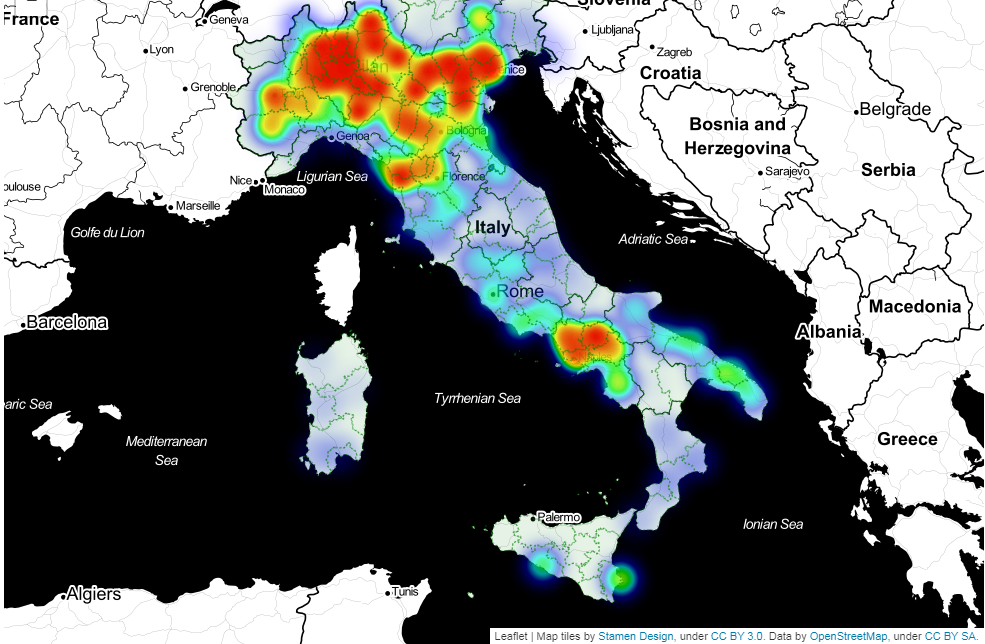

In [69]:
from IPython.display import Image

Image(filename="Images/ipyleaflet-italy.png")